In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import pandas as pd
import pymc3 as pm3
import statsmodels.formula.api as smf
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
import theano.tensor as T

np.random.seed(348348756)

plt.style.use('ggplot')

## 1. Introduction
### 1.1 Research Question
This paper aims to estimate the parameters in Cobb-Douglass function for China based on sector data from 1978 to 2006 and use an endogenous switching model to test whether there is a structural shift from 1952 to 1998 based on another data set. These two estimations try to answer two bigger questions: 1. What are the sources of the miraculous economic growth in China? Is the labor or capital the driving force of economic growth? 2. Whether key political and economic events lead to structural changes in economics? 

In their seminal work, Chow and Li (2002) estimate the parameters in Cobb-Douglass function for China based on the data from 1952 to 1998 and find that China has approximately constant to return to scale. This paper make serval new contributions to this issue: 1. instead of adding a time trend to deal with the time series data, we conduct cointegration test and keep the estimation in levels; 2. instead of estimating the whole new economy, we use a new data set constructed in Wu(2009) to estimate the parameters by sector with a hierarchal Bayesian model; 3. We extend the Chow’s analysis by testing whether there is a structural break from 1952 to 1998.

Serval results emerge: in each sector, China had increasing return to scale during the sample period, each sector has very different parameters, and there are two structural breaks: one is around the cultural revolution (1966-1976) and another one is around economic reform in 1978. 


### 1.2 Literature Review
Economists explain the miraculous economic growth of China in the post-reform era (after 1978) from various perspectives. Chow and Li (2002) construct the capital stock data and estimate the parameters in Cobb-Douglass function based on data from 1952 to 1998. They exclude the years from 1958 to 1969 because the data during that period is unreliable and include a time trend to deal with the non-stationarity. They find that the total factor productivity is 1.74, parameters for capital input is 0.6136, and parameters for labor input is about 0.4118, which approximately follows a constant return to scale. Following their work, Ozyurt (2009) estimates the parameters for Cobb-Douglass function for China with a longer sample period, from 1952 to 2005. She relaxes the restriction for constant return to scale and does not include a time trend in the regression. In addition to normal OLS, she also estimates an AR(1) and ARMA(1,1) model. Results from all three specifications show that the parameter for capital is around 0.8 and is around 0.25 for labor input. She argues that capital accumulation is the main cause of the economic growth of China in the sample period. 

Two works above focus on the whole Chinese economy. Some scholars analyze the economic growth of China from different sectors. Fan et al. (1999) analyze the economic growth from four sectors: urban industry, urban services, agriculture, and rural enterprises. They focus on the reallocation of resources to different sectors. Hu and McAleer (2005) estimate the production efficiency of agriculture sector based on panel data from 1991 to 1997. 

My paper is an extension of the two approaches above. I estimate the parameters for Cobb-Douglass function across three sectors: agriculture, manufacture, and service. As Bulman and Kraay (2011) point out, in addition to growth in the accumulation of capital and labor and the growth of total factor productivity, structural transformation also largely accounts for the economic growth of China. Thus, I will combine the underlying structural change to interpret my estimation results. Coase and Wang (2016) and Vogel (2011) comprehensively describe the structural changes in the sample period. 

Regarding the issue of the structural break, You and Sarantis(2013) estimate the structural break for the parameters in Cobb-Douglass function by the method from Bai and Perron (2003) to capture multiple structural breaks from 1980 to 2010. They found that two structural breaks happen near the Tiananmen Square protests in 1989 and implementation of the further reforms and opening-up measures in 1995. Their results indicate that the key political events and economic policies change may be associated with structural shift in the parameters of the production function. My analysis will focus on a different time period, from 1952 to 1998, based on the data from Chow and Li(2002) and use the endogenous switching model to identify multiple structural breaks. 


### 1.3 Data Description
I use two datasets in this paper. The first dataset is a panel data from 1978 to 2006, including the real gross domestic output, labor population, capital stock for agriculture, manufacture, and service sector. The data of capital stock and gross domestic output comes from Wu(2009). He estimates the capital depreciation rates and deflators to construct the capital stock for each sector. The labor population for each sector comes from the 2006 China Statistical Yearbook of National Bureau of Statistic. With this dataset by sector, I can estimate the parameters by sector. I will use this data set to run a basic model and a hierarchal model to estimate the parameters for the Cobb Douglass function.  

Note that in the following code, we import the dataset twice with different arrangements of data. One is more suitable for running time series analysis (data_sector) and another one is more suitable for the hierarchal model (hier_data). 

The second data set is a time series data from 1952 to 1998, including the total real GDP, labor population, and capital stock. It comes from Chow and Li (2002). For both data set, the base year is 1978 and unit of capital stock and GDP is 100 million yuan. The unit for labor force is 100 million. 

### 1.4 Organization
The rest of the paper is organized as follows: section 2 conducts time series analysis to the data, section 3 estimates the basic the model, section 4 estimates the hierarchal model, section 5 presents the endogenous switching model to test structural break, section 6 discusses model selection, and section 7 concludes. 

## 2. Time Series Analysis
The Cobb Douglass Fucntion is usually written as: 
$Y = AL^{\alpha}K^{\beta}$, where A is the total factor of productivity, L is the labor input, and K is the capital input. To estimate A, $\beta$, $\alpha$ in a OLS manner, we will take the log for both sides and so we have: 
$ log(Y) = A+\alpha log(L)+\beta log(K) $

Because we have a time series data, we will test the stationarity and cointegration of the log data from the first data set before running our model.

In [2]:
df1 = pd.read_excel('/Users/martin/Desktop/Bayesian_Final/data_sector.xlsx')

In [3]:
df1.head()

,year,ag_cap,man_cap,se_cap,ag_pop,man_pop,se_pop,ag_grp,man_grp,se_grp,...,lsecap,lagpop,lmanpop,lsepop,laggrp,lmangrp,lsegrp,ltcap,ltpop,ltgrp
0,1978,1769.0,5606.8,2816.6,2.8318,0.6945,0.4890,1011.9,1802.0,658.2,...,7.943286,1.040913,-0.364563,-0.715393,6.919585,7.496652,6.489509,9.229398,1.390112,8.152515
1,1979,1880.9,5951.1,3139.7,2.8634,0.7214,0.5177,1087.1,1956.8,720.4,...,8.051883,1.052010,-0.326562,-0.658359,6.991269,7.579066,6.579807,9.303075,1.411597,8.233317
2,1980,1977.5,6311.8,3468.8,2.9122,0.7707,0.5532,1106.5,2174.5,821.5,...,8.151564,1.068909,-0.260456,-0.592036,7.008957,7.684554,6.711132,9.372298,1.443643,8.319352
3,1981,2050.6,6645.5,3813.4,2.9777,0.8003,0.5945,1208.3,2214.7,911.6,...,8.246276,1.091151,-0.222769,-0.520035,7.096970,7.702872,6.815201,9.434244,1.475335,8.374385
4,1982,2142.6,7107.1,4238.9,3.0859,0.8346,0.6090,1355.1,2358.1,1040.1,...,8.352059,1.126843,-0.180803,-0.495937,7.211631,7.765611,6.947072,9.509600,1.510612,8.466594


### 2.1 stationarity
We begin by visualizing the data.

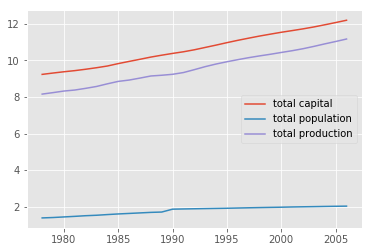

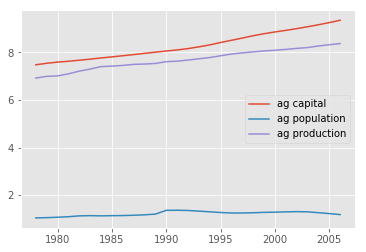

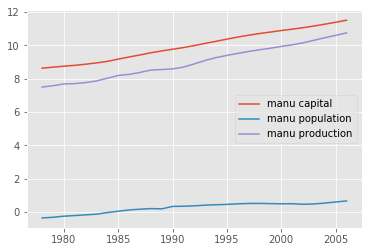

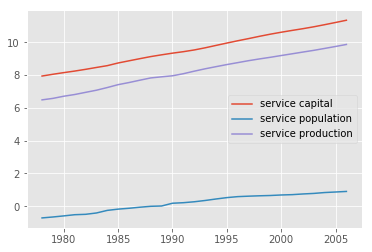

In [4]:
plt.plot(df1.year,df1.ltcap,label='total capital')
plt.plot(df1.year,df1.ltpop,label='total population')
plt.plot(df1.year,df1.ltgrp,label='total production')


plt.legend()
plt.show()

#Plot the agriculture graph

plt.plot(df1.year,df1.lagcap,label='ag capital')
plt.plot(df1.year,df1.lagpop,label='ag population')
plt.plot(df1.year,df1.laggrp,label='ag production')

plt.legend()
plt.show()

#Plot the manufacture graph

plt.plot(df1.year,df1.lmancap,label='manu capital')
plt.plot(df1.year,df1.lmanpop,label='manu population')
plt.plot(df1.year,df1.lmangrp,label='manu production')

plt.legend()
plt.show()

#Plot the service graph
plt.plot(df1.year,df1.lsecap,label='service capital')
plt.plot(df1.year,df1.lsepop,label='service population')
plt.plot(df1.year,df1.lsegrp,label='service production')

plt.legend()

plt.show()

The plot above shows that all variables in each sector do not seem to have stationarity. To give a more formal test, we will use the Augmented Dicky-Fuller(ADF) test from Fuller(1996) to examine the stationarity. The null hypothesis for ADF test is the data has a unit root and thus it is not stationary. 


In [5]:
l_r1 = adfuller(df1.ltcap)
l_r2 = adfuller(df1.ltpop)
l_r3 = adfuller(df1.ltgrp)
print('p value for total variables is:',l_r1[1],l_r2[1],l_r3[1])

ag_r1 = adfuller(df1.lagcap)
ag_r2 = adfuller(df1.lagpop)
ag_r3 = adfuller(df1.laggrp)
print('p value for agriculture variables is:',ag_r1[1],ag_r2[1],ag_r3[1])

man_r1 = adfuller(df1.lmancap)
man_r2 = adfuller(df1.lmanpop)
man_r3 = adfuller(df1.lmangrp)
print('p value for manufacture variables is:',man_r1[1],man_r2[1],man_r3[1])

se_r1 = adfuller(df1.lsecap)
se_r2 = adfuller(df1.lsepop)
se_r3 = adfuller(df1.lsegrp)
print('p value for service is:',man_r1[1],man_r2[1],man_r3[1])

p value for total variables is: 0.9309616586784923 0.2520174502677523 0.995672583174555
p value for agriculture variables is: 0.9983501344359779 0.2442860455756683 0.9070910741492195
p value for manufacture variables is: 0.6176238934800028 0.17276945060422094 0.9942217817248742
p value for service is: 0.6176238934800028 0.17276945060422094 0.9942217817248742


The results above indicate that we cannot reject the null hypothesis even in a 90% confidence level as all p-values are larger than 15%. Thus, all variables are non-stationary. Before going to detrend the data, the visualization above indicate some hints for cointegration. Thus, we will conduct a Johansen cointegration test from Johansen (1991) to test whether GDP, labor force and capital have cointegration vector in each sector and in total value. 

### 2.2 Cointegration

In [6]:
frame1=['lagcap','lagpop','laggrp']
result1=coint_johansen(df1[frame1], 0, 1)
r1=0
for i in range(3):
    if result1.lr1[i] > result1.cvt[i, 1]:     # 0: 90%  1:95% 2: 99%
        r1 +=1
print('There are',r1, 'cointegration vector for agriculture')

frame2=['lmancap','lmanpop','lmangrp']
result2=coint_johansen(df1[frame2], 0, 1)
r2=0
for i in range(3):
    if result2.lr1[i] > result2.cvt[i, 1]:     # 0: 90%  1:95% 2: 99%
        r2 +=1
print('There are',r2, 'cointegration vector for manufacture')

frame3=['lsecap','lsepop','lsegrp']
result3=coint_johansen(df1[frame3], 0, 1)
r3=0
for i in range(3):
    if result3.lr1[i] > result3.cvt[i, 1]:     # 0: 90%  1:95% 2: 99%
        r3 +=1
print('There are',r3, 'cointegration vector for service')

frame4=['ltcap','ltpop','ltgrp']
result4=coint_johansen(df1[frame4], 0, 1)
r4=0
for i in range(3):
    if result4.lr1[i] > result4.cvt[i, 1]:     # 0: 90%  1:95% 2: 99%
        r4 +=1
print('There are',r4, 'cointegration vector for total production')

There are 0 cointegration vector for agriculture
There are 1 cointegration vector for manufacture
There are 1 cointegration vector for service
There are 1 cointegration vector for total production


In [89]:
frame1=['lagcap','lagpop','laggrp']
result1=coint_johansen(df1[frame1], 0, 1)
r1=0
for i in range(3):
    if result1.lr1[i] > result1.cvt[i, 0]:     # 0: 90%  1:95% 2: 99%
        r1 +=1
print('There are',r1, 'cointegration vector for agriculture')

There are 1 cointegration vector for agriculture


The results above indicate that for total value, manufacture and service sector, they have one cointegrating vector in a 95% confidence level. For agriculture, if we lower the standard to 90% confidence level, we can find a cointegrating vector. Thus, we will proceed by running the model in levels. 


## 3. Basic Model

### 3.1 Run the model

In [7]:
#Import the data set by sector in another format
df2 = pd.read_excel('/Users/martin/Desktop/Bayesian_Final/hier_data.xlsx')

In [8]:
#Generate the log value
df2['lgdp']= np.log(df2.grp)
df2['lpop']= np.log(df2.popu)
df2['lcap']= np.log(df2.cap)

In [9]:
df2.head()

,year,cap,popu,grp,ones,sector,lgdp,lpop,lcap
0,1978,1769.0,2.8318,1011.9,1,0,6.919585,1.040913,7.478170
1,1978,5606.8,0.6945,1802.0,1,1,7.496652,-0.364563,8.631735
2,1978,5606.8,0.4890,658.2,1,2,6.489509,-0.715393,8.631735
3,1979,1880.9,2.8634,1087.1,1,0,6.991269,1.052010,7.539506
4,1979,5951.1,0.7214,1956.8,1,1,7.579066,-0.326562,8.691331


In this section, we use a Bayesian approach to run an OLS regression to the total level of output, labor force, and capital. The equation is the following: 
$$  log(Y_{j,t}) = A+\alpha log(L_{j,t})+\beta log(K_{j,t}),  $$
where j denotes observations in three different sectors and t denotes observation in different time period. We will start with a frequentist OLS regression as a benchmark to our Bayesian method. 


In [10]:
smf.ols('lgdp~lcap+lpop',data=df2).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   lgdp   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     876.2
Date:                Sat, 04 May 2019   Prob (F-statistic):           5.42e-57
Time:                        11:35:04   Log-Likelihood:                 9.8891
No. Observations:                  87   AIC:                            -13.78
Df Residuals:                      84   BIC:                            -6.381
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1032      0.202     -0.510      0.611      -0.505       0.299
lcap           0.8786      0.021     41.478      0.000       0.836       0.921
lpop           0.4158      0.041     10.201      0.000       0.335       0.497
==============================================================================
Omnibus:                        1.043   Durbin-Watson:                   2.734
Prob(Omnibus):                  0.594   Jarque-Bera (JB):                0.770
Skew:                          -0.229   Prob(JB):                        0.681
Kurtosis:                       3.043   Cond. No.                         81.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the OLS results, we know that the coefficient for capital input is 0.87 and for labor input is 0.41, which indicates an increasing return to scale. However, the negative total factor productivity (-0.1032) does not make economic sense. We will deal with this issue in our Bayesian approach below.

We will set the prior for total productivity factor (intercept) as a uniform distribution from 0.001 to 10 because its value will only make economic sense if the value is positive.  I assume that the capital and labor both have decreasing return to scale and thus set the prior with a uniform distribution from 0.001 to 0.999. For sigma, I set it as a half normal with standard deviation with 20 to keep it positive. We run the Bayesian OLS with a No U-Turn Sampler (NUTS). 

In [11]:
#Basic model
basic_model = pm3.Model()

with basic_model:
    intercept = pm3.Uniform('Intercept',lower=0.0001,upper=10)
    capital = pm3.Uniform('capital',lower=0.0001,upper=0.9999)
    labor = pm3.Uniform('labor',lower=0.0001,upper=0.9999)
    sigma = pm3.HalfNormal('Sigma',sd = 20)
    
        
    
    mu = intercept + capital*df2.lcap+labor*df2.lpop
    
    like = pm3.Normal('Likelihood',mu=mu,sd=sigma,observed=df2.lgdp)

In [12]:
with basic_model:
    step = pm3.NUTS()
    trace1 = pm3.sample(4000,tune=2000,nuts_kwargs=dict(target_accept=0.98))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Sigma, labor, capital, Intercept]
Sampling 2 chains: 100%|██████████| 12000/12000 [01:11<00:00, 166.87draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [13]:
pm3.summary(trace1[2000:])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,0.127622,0.107844,0.003023,0.000105,0.341856,1133.768535,1.003204
capital,0.854737,0.011698,0.000334,0.829996,0.872546,1142.329377,1.003303
labor,0.406218,0.042820,0.000908,0.318927,0.485944,2206.295296,1.000054
Sigma,0.224039,0.017688,0.000351,0.192275,0.262384,2198.203241,1.000493


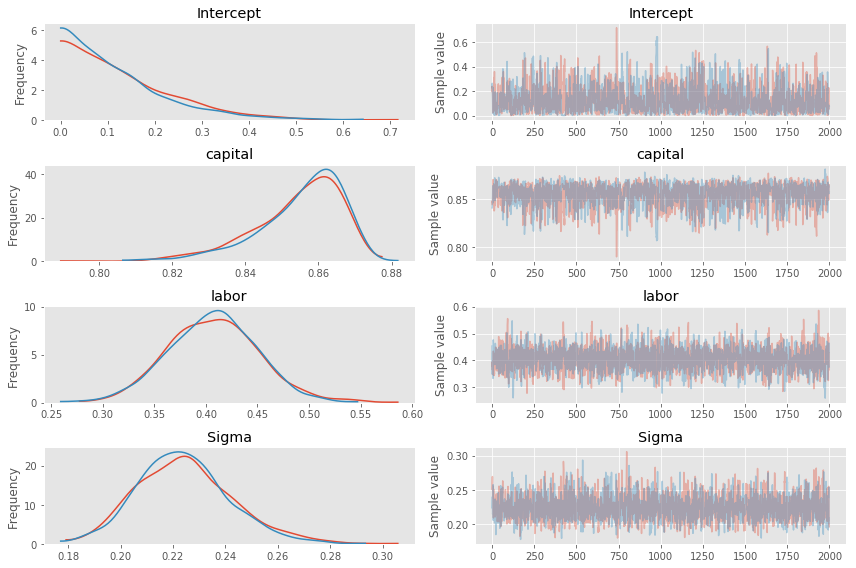

In [14]:
pm3.traceplot(trace1[2000:]);

The results above are very close to estimations from the simple OLS regression model. But we have positive total factor productivity. The Intercept is  0.129503, the coefficient for capital is 0.854523 and the coefficient for labor is 0.406182. This result means that a 1% increase in capital will lead to about 0.85% increase in output, given the same labor force and total factor productivity. Similarly, a 1% increase in labor will lead to about 0.406% increase in output given the same capital input and total factor productivity. 

Though the Gelman-Rubin statistic is very small (Rhat) and thus the sampler converges, sometimes there is a warning message about divergence after running the sampler. We will explore the potential issue with the following code and figure. 

### 3.2 Warning Message

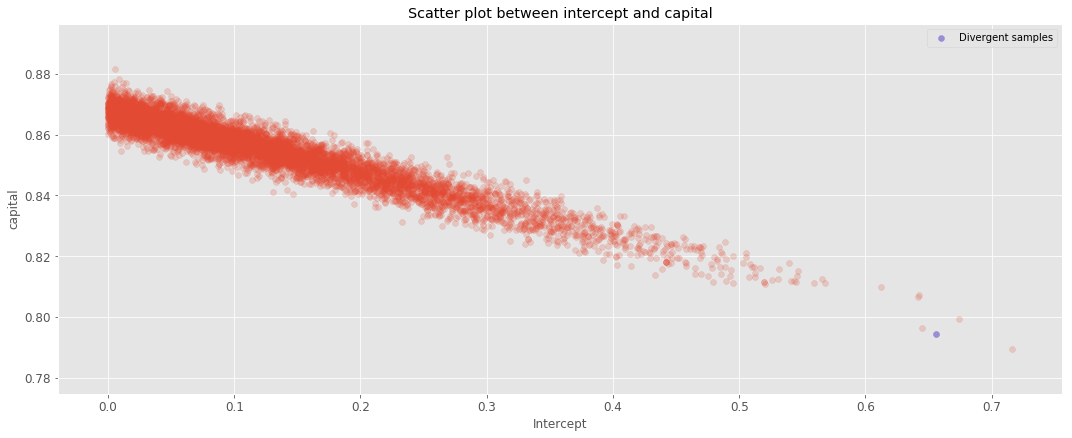

In [15]:
_, ax = plt.subplots(1, 1, figsize=(15, 6), sharex=True, sharey=True)

pm3.pairplot(trace1,
               sub_varnames=['Intercept', 'capital'],
               divergences=True,
               ax=ax,
               color='C7', alpha=0.2, figsize=(12, 10),
               kwargs_divergence={'color':'C2', 'label':'Divergent samples'})

plt.title('Scatter plot between intercept and capital')
plt.legend();

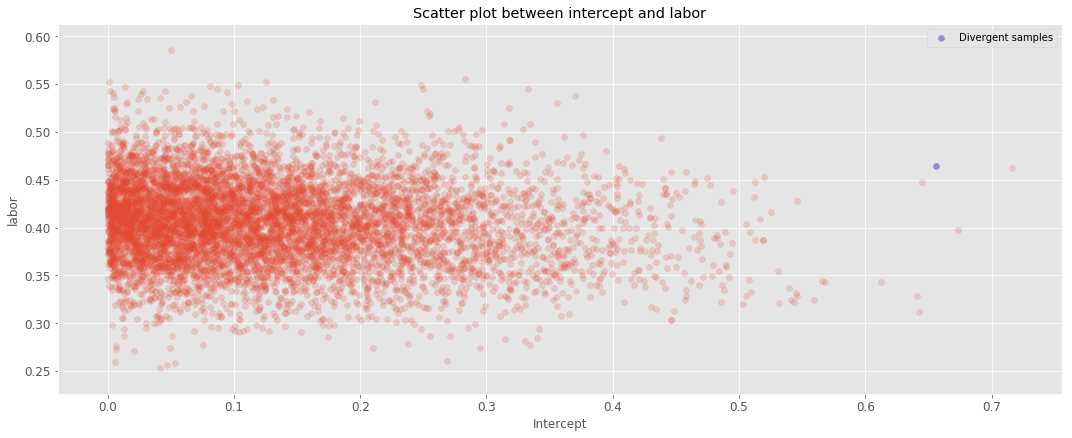

In [41]:
_, ax = plt.subplots(1, 1, figsize=(15, 6), sharex=True, sharey=True)

pm3.pairplot(trace1,
               sub_varnames=['Intercept', 'labor'],
               divergences=True,
               ax=ax,
               color='C7', alpha=0.2, figsize=(12, 10),
               kwargs_divergence={'color':'C2', 'label':'Divergent samples'})

plt.title('Scatter plot between intercept and labor')
plt.legend();

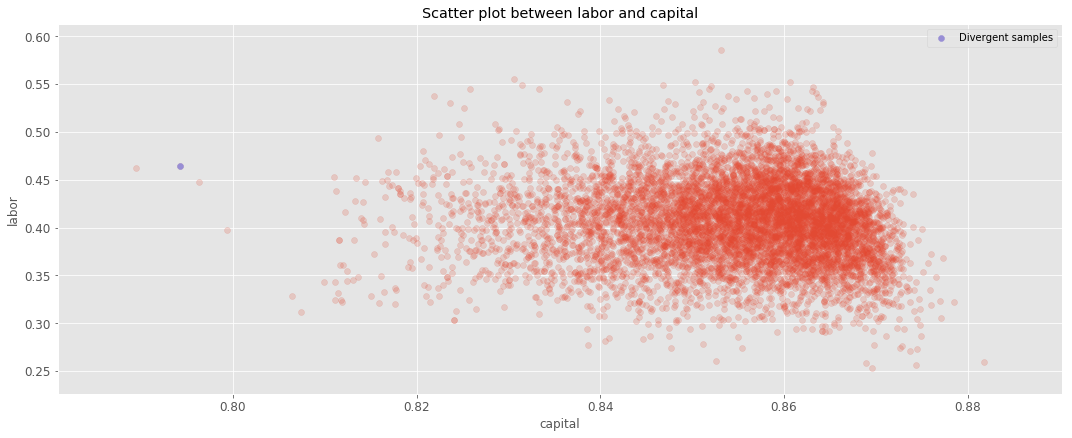

In [17]:
_, ax = plt.subplots(1, 1, figsize=(15, 6), sharex=True, sharey=True)

pm3.pairplot(trace1,
               sub_varnames=['capital', 'labor'],
               divergences=True,
               ax=ax,
               color='C7', alpha=0.2, figsize=(12, 10),
               kwargs_divergence={'color':'C2', 'label':'Divergent samples'})

plt.title('Scatter plot between labor and capital')
plt.legend();

By making the pairwise plot, the geometry between intercept and capital seems to make the sampler have a hard time to explore the parameter space. This may be due to our constraints to the value of intercept. The sampler tries to push the intercept to a negative value but the constraint we impose does not allow this to happen. So a  lot of draws for the intercept cluster near 0 and lead to the geometry shape in scatter plot between intercept and capital. However, the divergence is usually very small (less than 10) and does not concentrate anywhere in the parameter space. This is not a too serious issue and we will proceed to the hierarchical model.

## 4. Hierarchical  Model

### 4.1 Run the Model

In this section, we will estimate a hierarchical model with varying intercepts and coefficients by sector. The equation will become the following: 

$$  log(Y_{j,t}) = A_{j}+\alpha_{j} log(L_{j,t})+\beta_{j} log(K_{j,t}),  $$
where $\beta_{j}$,$\alpha_{j}$  refers to the coefficient for a specific sector. For each coefficient, we have a “parent” prior; that is, the coefficient for each sector is centered around them. When drawing prior to observations, we have “children” prior to each sector; that is, we group observations by sector and give each group different prior. In the pymc3 code, we use the sector index to distinguish each group. So we can estimate the parameters for agriculture, manufacture and service sector respectively. Again, to make total productivity factor as positive, we impose prior that follows a uniform distribution from 0.0001 to 10 and also make the total productivity varying by sector by using the sector index. To hold the assumption that capital has a decreasing return to scale, we introduce a new parameter in the pymc3- capital_star. It is calculated by the following formula: \frac{capital^e}{1+capital^e), where capital is the prior we draw for the parameters for capital input. We store the value of capital star for each draw by using the pm3.Deterministic in the code. Thus, we can constrain the parameters to a value that is between 0 and 1 as
$0 < \frac{capital^{e}}{1+capital^{e}} <1 $.


In [18]:
sector_idx = df2['sector'].values.astype(int)
sector_n = len(np.unique(sector_idx))

In [19]:
# heirarchical model
hier_model = pm3.Model()

with hier_model:
    # hierarchical parent variables
    mu_cap = pm3.Uniform('labor mean',lower=0.0001,upper=0.9999)
    sigma_cap = pm3.HalfNormal('capital Sigma',sd = 20)
    mu_pop = pm3.Uniform('capital mean',lower=0.0001,upper=0.9999)
    sigma_pop = pm3.HalfNormal('Population Sigma',sd = 20)

    # hierarchical children variables
    capital = pm3.Normal('capital',mu = mu_cap, sd = sigma_cap,shape=sector_n)
    population = pm3.Normal('population',mu = mu_pop, sd = sigma_pop, shape=sector_n)
    intercept = pm3.Uniform('Sector Intercept', lower=0.0001,upper=10, shape=sector_n)
    
    #Normal variables
    sigma = pm3.HalfNormal('Sigma',sd = 20)
    
    capital_star = T.exp(capital)/(1+T.exp(capital))
    
    b = pm3.Deterministic("Constrained Capital", capital_star)
    
    mu = intercept[sector_idx] + capital_star[sector_idx]*df2.lcap+population[sector_idx]*df2.lpop
    
    like = pm3.Normal('Likelihood',mu=mu,sd=sigma,observed=df2.lgdp)

In [20]:
with hier_model:
    step = pm3.NUTS()
    trace2 = pm3.sample(5000,tune=2000,nuts_kwargs=dict(target_accept=0.95))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Sigma, Sector Intercept, population, capital, Population Sigma, capital mean, capital Sigma, labor mean]
Sampling 2 chains: 100%|██████████| 14000/14000 [11:24<00:00,  7.21draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [22]:
pm3.summary(trace2[2000:])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
capital__0,0.633317,0.155282,0.002532,0.328381,0.935417,3786.085058,0.999959
capital__1,1.955409,0.092370,0.002196,1.755592,2.082787,1933.488692,0.999950
capital__2,-0.004386,0.316266,0.007710,-0.619962,0.635385,1764.139915,1.000937
population__0,0.728658,0.193947,0.002724,0.316997,1.087121,4728.647275,1.000102
population__1,0.584549,0.068467,0.001151,0.451364,0.720214,3688.257554,1.000018
population__2,1.029882,0.150227,0.003639,0.730423,1.330229,1766.940346,1.000896
labor mean,0.558768,0.277028,0.003385,0.077941,0.998959,6093.033262,0.999947
capital Sigma,1.826927,1.774288,0.032093,0.381510,4.670831,3020.489958,0.999834
capital mean,0.679442,0.213724,0.003110,0.233496,0.999867,4452.015804,0.999915
Population Sigma,0.616139,0.891160,0.020165,0.009902,1.739215,1904.172811,0.999838


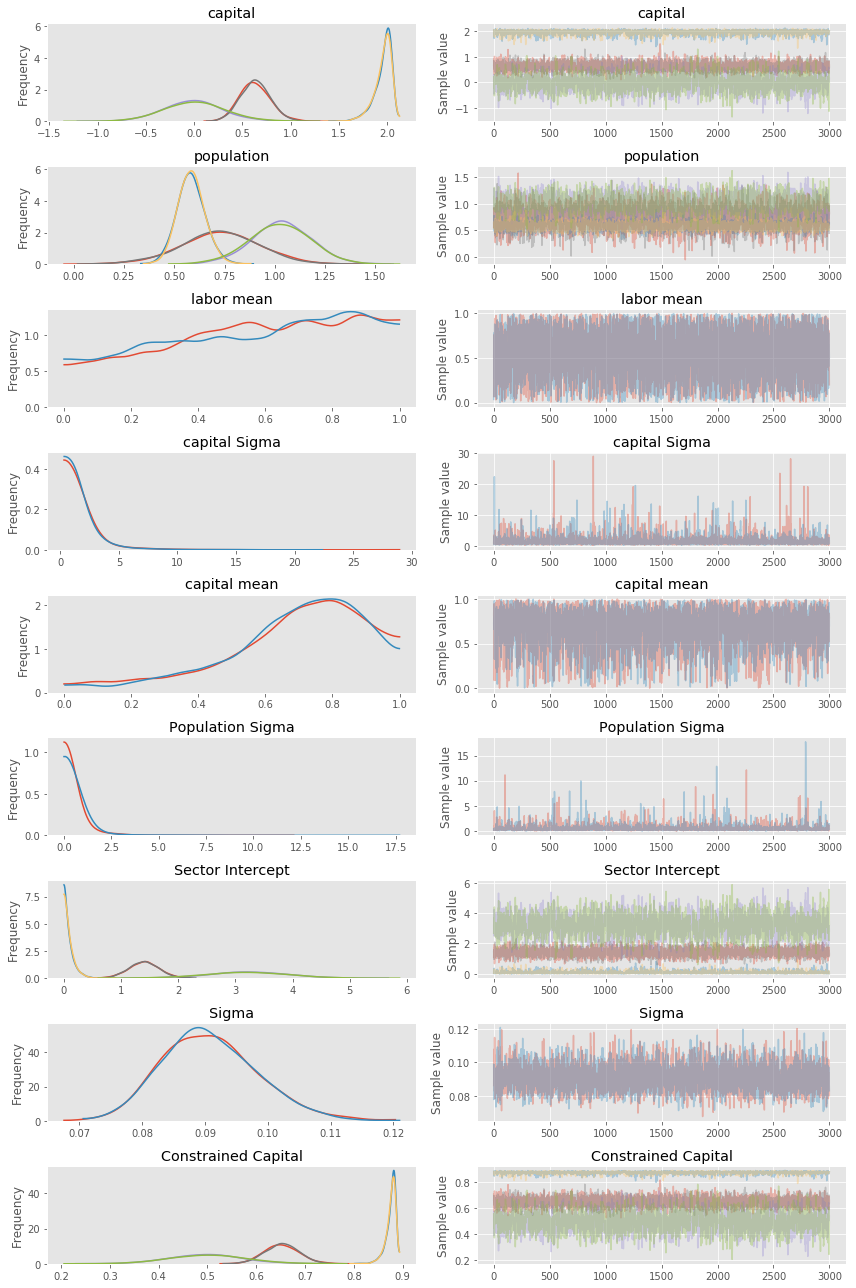

In [23]:
pm3.traceplot(trace2[2000:]);

The estimation indicates an increasing return of scale for each sector. For the agriculture sector, the intercept is 1.3997, the coefficient for capital is 0.653377 and the coefficient for labor is 0.724332. So a 1% increase in agriculture capital input will lead to about 0.65% increase in output, given the same labor force and total factor productivity. A 1% increase in agriculture labor input will lead to about 0.72% increase in output, given the same capital input and total factor productivity. We can interpret the result for manufacture and service sector similarly. Note that sector 2 refers to the manufacturing sector and sector 3 refers to the service sector. We will discuss more the sector heterogeneity in the conclusion after selecting model. 

Though the Gelman-Rubin statistic is very small (Rhat) and thus the sampler converges, sometimes there is a warning message about divergence after running the sampler. We will explore the potential issue with the following code and figure. 


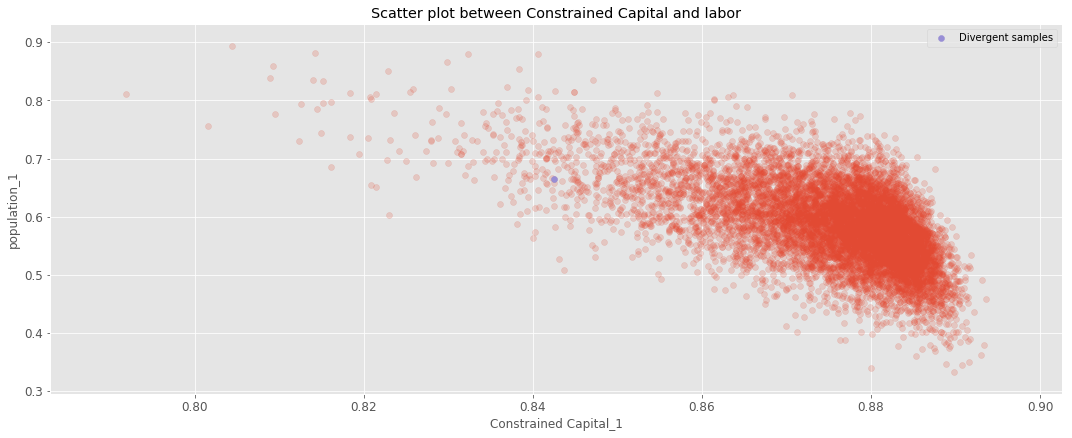

In [59]:
_, ax = plt.subplots(1, 1, figsize=(15, 6), sharex=True, sharey=True)

pm3.pairplot(trace2,
               sub_varnames=['Constrained Capital_1', 'population_1'],
               divergences=True,
               ax=ax,
               color='C7', alpha=0.2, figsize=(12, 10),
               kwargs_divergence={'color':'C2', 'label':'Divergent samples'})

plt.title('Scatter plot between Constrained Capital and labor')
plt.legend();

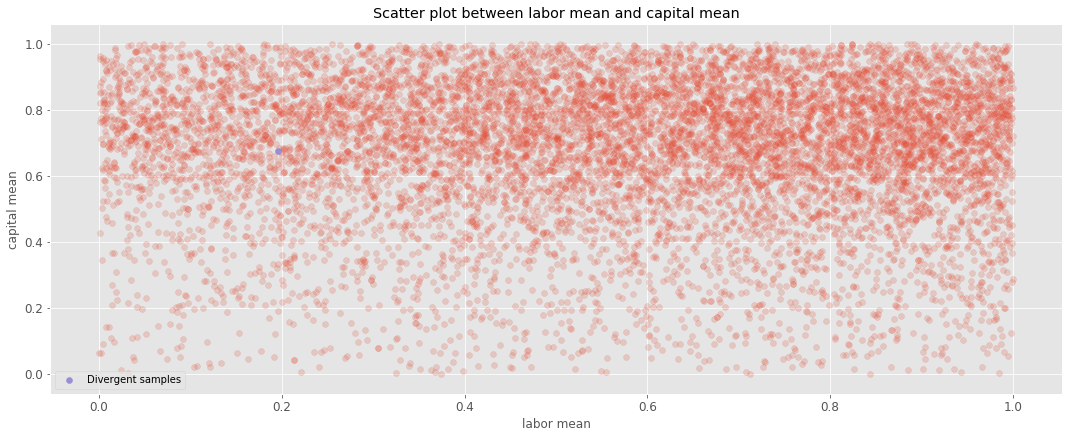

In [90]:
_, ax = plt.subplots(1, 1, figsize=(15, 6), sharex=True, sharey=True)

pm3.pairplot(trace2,
               sub_varnames=['labor mean', 'capital mean'],
               divergences=True,
               ax=ax,
               color='C7', alpha=0.2, figsize=(12, 10),
               kwargs_divergence={'color':'C2', 'label':'Divergent samples'})

plt.title('Scatter plot between labor mean and capital mean')
plt.legend();

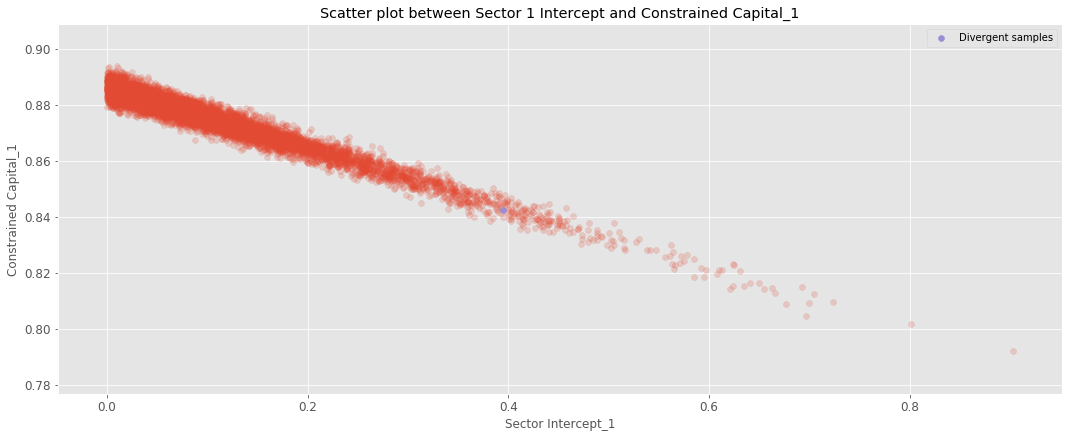

In [91]:
_, ax = plt.subplots(1, 1, figsize=(15, 6), sharex=True, sharey=True)

pm3.pairplot(trace2,
               sub_varnames=['Sector Intercept_1', 'Constrained Capital_1'],
               divergences=True,
               ax=ax,
               color='C7', alpha=0.2, figsize=(12, 10),
               kwargs_divergence={'color':'C2', 'label':'Divergent samples'})

plt.title('Scatter plot between Sector 1 Intercept and Constrained Capital_1')
plt.legend();

By making the pairwise plot, the geometry between sector 2 intercept and capital sector 2 seems to make the sampler have a hard time to explore the parameter space. This may be due to our constraints to the value of intercept. The sampler tries to push the intercept to a negative value but the constraint we impose does not allow this to happen. So a  lot of draws for the intercept cluster near 0 and lead to the geometry shape in scatter plot between intercept and capital. However, the divergence is usually very small (less than 10) and does not concentrate anywhere in parameter space. So it is not a too serious issue.

## 5. Structural Break Test 

### 5.1 Run the Model

We use an endogenous switching point model to identify the structural shift of the model parameters during our sample period. Compared to other approaches for testing structural break, this Bayesian method doesn’t need us to pre-impose the breakpoint and enables us to estimate how likely each period will be a structural breakpoint. 

The basic idea is that we create a prior called t star from a discrete uniform distribution so it can sample each year in our sample period. Then each coefficient will have two prior- one denotes the prior before the breakpoint (pre) and another denotes the prior after the breakpoint (post). Then we use the pymc3 switch method to calculate the likelihood before and after a realization t star (a year). After sampling, we can find in what year the switching most likely occur by observing the posterior distribution of t_star.

We use Chow’s data from 1952 to 1998 to conduct this test as it contains a longer period. To avoid problems for non-stationarity, we take the first difference of all the data. 


In [24]:
#Now we will load the data for testing structural break
df3 = pd.read_excel('/Users/martin/Desktop/Bayesian_Final/Chow_data.xlsx')

In [25]:
df3['lgdp']= np.log(df3.RGDP)
df3['lpop']= np.log(df3.L)
df3['lcap']= np.log(df3.K)

In [26]:
df3.head()

,Year,RGDP,L,K,trend,lgdp,lpop,lcap
0,1952,799.32,2.0729,2212.993,0,6.683761,0.728949,7.702101
1,1953,911.22,2.1364,2380.993,0,6.814784,0.759122,7.775273
2,1954,963.98,2.1832,2575.993,0,6.871071,0.780792,7.853990
3,1955,1025.52,2.2328,2760.993,0,6.932955,0.803256,7.923346
4,1956,1170.20,2.3018,2977.993,0,7.064930,0.833691,7.999005


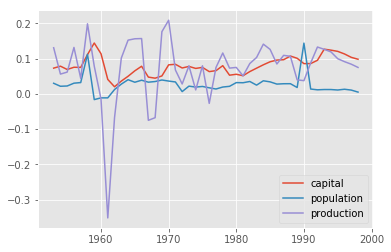

In [27]:
plt.plot(df3.Year,df3.lcap.diff(),label='capital')
plt.plot(df3.Year,df3.lpop.diff(),label='population')
plt.plot(df3.Year,df3.lgdp.diff(),label='production')
plt.legend()
plt.show()

In [28]:
# create diff variables
dlcap = df3.lcap.diff().values[1:]
dlpop = df3.lpop.diff().values[1:]
dlgdp = df3.lgdp.diff().values[1:]
dyear = df3.Year.values[1:]

In [29]:
with pm3.Model() as structural_model:

    t_star = pm3.DiscreteUniform('t_star', lower=dyear.min()+5, upper=dyear.max()-5, testval=1975)
    
    # Priors for pre- and post-switch rates 
    intercept_pre = pm3.Flat('intercept_pre')
    intercept_post = pm3.Flat('intercept_post')
    cap_pre = pm3.Uniform('cap_pre', lower=0.0001,upper=0.9999)
    pop_pre = pm3.Uniform('pop_pre', lower=0.0001,upper=0.9999)
    cap_post = pm3.Uniform('cap_post', lower=0.0001,upper=0.9999)
    pop_post = pm3.Uniform('pop_post', lower=0.0001,upper=0.9999)
    mu_pre = intercept_pre + cap_pre*dlcap+pop_pre*dlpop
    mu_post = intercept_post + cap_post*dlcap+pop_post*dlpop
    sigma_pre = pm3.HalfNormal('Population pre Sigma',sd = 20)
    sigma_post = pm3.HalfNormal('Population post Sigma',sd = 20)
    
    mu = T.switch(t_star >= dyear, mu_post, mu_pre)
    sigma = T.switch(t_star >= dyear, sigma_post, sigma_pre)

    likelihood = pm3.Normal('likelihood', mu=mu, sd=sigma,observed=dlgdp)

In [81]:
with structural_model:    
    step = pm3.NUTS()
    trace3 = pm3.sample(10000,step=step,tune=3000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [Population post Sigma, Population pre Sigma, pop_post, cap_post, pop_pre, cap_pre, intercept_post, intercept_pre]
>Metropolis: [t_star]
Sampling 2 chains: 100%|██████████| 26000/26000 [01:23<00:00, 312.80draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [82]:
pm3.summary(trace3[3000:])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
t_star,1972.720214,3.005341,0.178557,1969.000000,1977.000000,232.502093,1.000005
intercept_pre,0.027994,0.024684,0.000822,-0.013484,0.077271,775.713821,1.000086
intercept_post,-0.002713,0.035106,0.000383,-0.070480,0.066692,8728.332215,0.999929
cap_pre,0.618164,0.241295,0.006113,0.174634,0.999769,1479.835134,0.999966
pop_pre,0.158563,0.142635,0.002466,0.000105,0.446121,3629.555472,1.000380
cap_post,0.599099,0.274957,0.002954,0.096096,0.999751,9334.798298,0.999929
pop_post,0.664660,0.256266,0.002352,0.162153,0.999894,11500.156702,0.999934
Population pre Sigma,0.035279,0.006735,0.000220,0.022633,0.048212,808.602078,1.000160
Population post Sigma,0.123682,0.024667,0.000603,0.080881,0.172040,1510.100198,0.999954


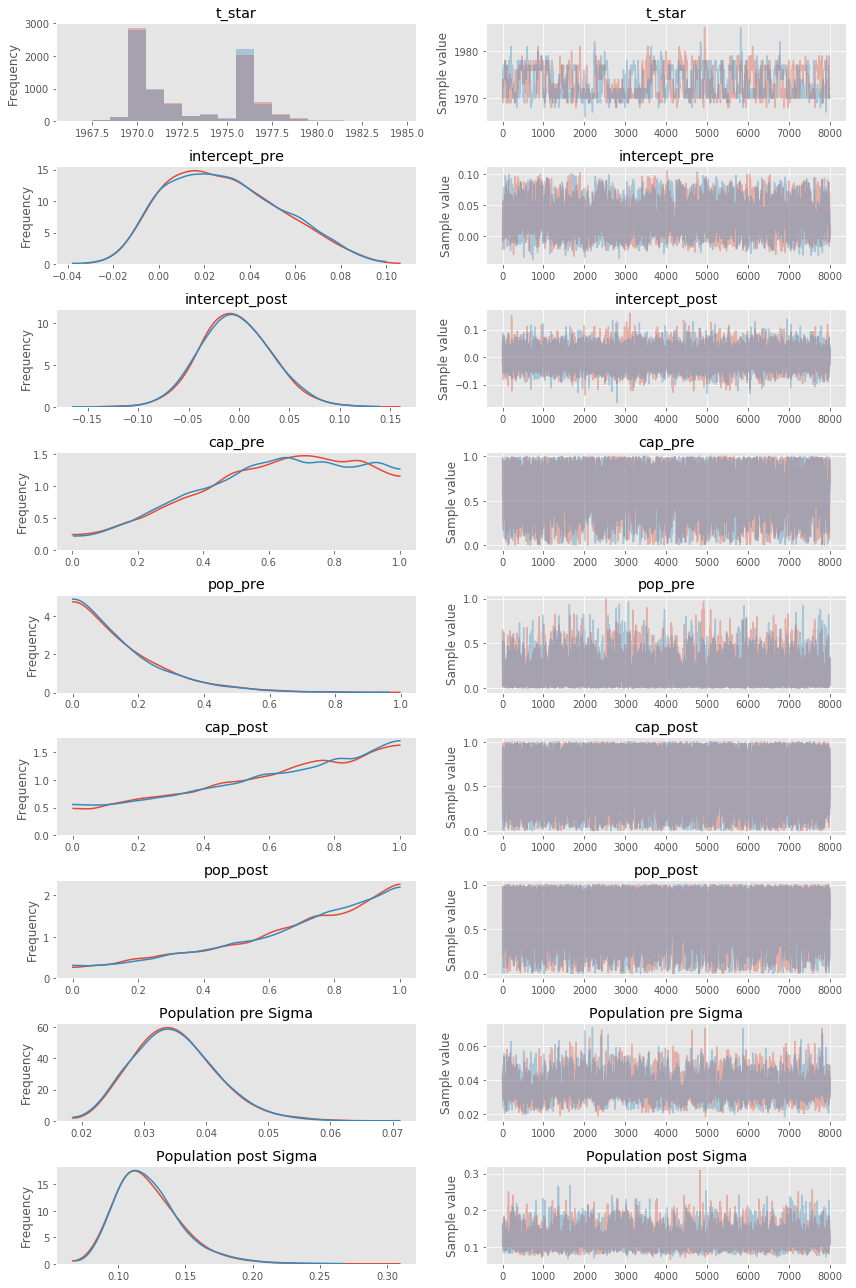

In [83]:
pm3.traceplot(trace3[2000:]);

Based on the results, one structural shift happens around 1969 when the cultural revolution achieve its peak and another structural shift occurs around 1977 when China entered the reformation era. In Cultural Revolution, young people were mobilized to attack high-level officials. Millions of people were persecuted and suffered various abuses. Productions in every sector were in disarray, which largely decreased the effect of any labor or capital input. In 1977, China shifted its focus from political struggle to economic development, entering the “reform and opening era”. The government conducted agricultural reformation, attracting foreign investment, and changed the incentive mechanism in industrial sectors, which increased the effect of labor and capital. Intuitively, structural shifts should happen at this time. Our statistical model agrees with the intuition. It shows that the key political events and economic policies change is closely related to the structure of the economy.

### 5.2 Effective Sample Size

For the model above, we see there is a warning message about effective size. Though there is no message about divergence, we will brief explore this issue because t_star, which we are interested in, has the smallest sample size. We begin the exploration by running a longer chain. 

In [87]:
with structural_model:    
    step = pm3.NUTS()
    trace4 = pm3.sample(20000,step=step,tune=3000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [Population post Sigma, Population pre Sigma, pop_post, cap_post, pop_pre, cap_pre, intercept_post, intercept_pre]
>Metropolis: [t_star]
Sampling 2 chains: 100%|██████████| 46000/46000 [02:26<00:00, 314.13draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [88]:
pm3.summary(trace4[3000:])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
t_star,1972.995853,3.036583,0.146385,1969.000000,1977.000000,344.317082,1.000361
intercept_pre,0.029368,0.025031,0.000668,-0.014481,0.077622,1232.779892,0.999980
intercept_post,-0.002617,0.034800,0.000297,-0.068689,0.067627,22239.048618,0.999983
cap_pre,0.607105,0.242278,0.004805,0.164573,0.999831,2488.194019,1.000014
pop_pre,0.156079,0.141500,0.001817,0.000105,0.439054,6196.226863,1.000017
cap_post,0.605372,0.272879,0.001921,0.104015,0.999737,24434.549459,0.999971
pop_post,0.660418,0.261741,0.002077,0.143937,0.999890,25461.965267,0.999974
Population pre Sigma,0.034760,0.006726,0.000175,0.022676,0.048257,1290.635681,1.000006
Population post Sigma,0.123044,0.024508,0.000518,0.081433,0.171368,1938.543710,1.000236


When we increase the sample size to 20000, the number of effective samples increase and the position of the two clear breakpoints do not change. More importantly, there is no divergence even we increase the sample size. Thus, though we do not explore the parameter spaces very efficiently, the MCMC estimators are not biased. So we can hold confident for our results. 

## 6.Model Selection

In [33]:
print("Model 1 WAIC: ", pm3.waic(trace1, model=basic_model))

/Users/martin/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)


Model 1 WAIC:  WAIC_r(WAIC=-11.040245871887773, WAIC_se=15.28954753098709, p_WAIC=3.6805763818021275, var_warn=1)


/Users/martin/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


In [34]:
print("Model 2 WAIC: ", pm3.waic(trace2,model=hier_model))

/Users/martin/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)


Model 2 WAIC:  WAIC_r(WAIC=-156.72986242840034, WAIC_se=22.88418341760965, p_WAIC=12.403015266321486, var_warn=1)


/Users/martin/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


We use the Widely Available Information Criteria (WAIC) to select between the basic model and the hierarchical model. We do not compare them with the structural break model because it uses a different data set and focuses on identifying structural shift. We prefer the model with lower WAIC. As the results above show, the hierarchical model has lower WAIC and thus we will choose it. We make most of our discussion below based on the results from the hierarchical model. 

## 7.Conclusion

Two important conclusions emerge from the hierarchical model: there is the increasing return to scale and sector heterogeneity.

We will first discuss the increasing return to scale. Increasing return to scale means that output increases by more than the proportional change in all inputs. In short, the structural change of economy and different incentive mechanism lead to increasing return to scale. We will discuss the specific changes in each sector. 

Before the reform period, China had collectivized agriculture. In other words, the whole villages share all the lands and the agricultural gains are equally distributed no matter how much a person worked. Thus, farmers did not have incentives to work hard. However, in the post-reform era, China gradually adopted the household responsibility system. In other words, each rural household is assigned land and responsible for the grain production in that land. The household needs to give part of its gain to the whole village but can keep the additional part.  This new allocation mechanism incentivized the farmers across China and the same labor and capital inputs lead to higher output than before. Thus, there is an increasing return to scale in the agriculture sector. 

For the manufacture and service sector, two important changes occurred- the reformation in the state-own enterprises(SOEs) and the emergence of the private sector economy. Before the reform area, the private sector was almost eliminated from the economy and state-owned enterprises dominated every area of the economy. In the SOEs, workers gained fixed wage no matter how hard they work. Also, SOEs only follow the instructions from the central and local governments to produce. In the post-reform era, the government gradually allow the private sectors to enter the economy and SOEs began to reform its rule. Workers are paid on a piecework basis. In other words, workers will earn work if they work harder. The emergence of private sector economies and the reform in SOEs together lead to more incentive for workers in manufacture and service sector to work harder and thus leads to increasing return to scale in these two sectors.

Now we will discuss the difference across sectors. In accordance with common sense, the manufacturing sector has higher parameters of capital input as it relies more on machines to produce and the service sector will have higher parameters for labor as it relies on human resource. For agriculture, labor input has higher parameters. Because agriculture in China is labor-intensive and rely less on agricultural machines. It has two reasons: one is the large population size in China and another is the main product-grain is more suitable for intensive labor. If compare our results from the hierarchical to the basic model, we will find that if we do not account for sector heterogeneity, the capital input seems to have a higher effect for the whole economy. However, this is not true for agriculture and service sector. Also, if we compare the labor mean and capital mean to the results in the basic model, though capital input still has higher parameter than the labor input, the difference between than is less in the hierarchical model. 

Linking our results back to larger literature, we agree with Chow and Li (2002 that capital accumulation plays a more important role in the whole economy. However, in agriculture and service sector, labor accumulation is more important. In contrast to Chow and Li (2002), we find that there is an increasing return to scale instead of constant return to scale when our sample period is from 1978 to 2006. This is because of the changing incentive mechanism and economic structure in the reform era. Regarding the question of structural break, we agree with You and Sarantis(2013) that key political and economic events lead to structural changes for the parameters in Cobb-Douglass production function. 

If we have more time and resources, there are serval things we can do. First, we can check the robustness of the capital data. There are serval other scholars have constructed the capital data by sector and we run the model to those datasets and see if we can similar results. Second, we can use the construction method to extend estimations of the capital stock to 2018. Thus, we can estimate the parameters in Cobb-Douglass function and test structural shifts  in a longer timeframe. It would be intriguing to see whether the emergence of Internet industry in China changes the economy structure. Third, we can collect the data of each province labor force by sector, we can estimate a hierarchal model by province and observe the difference across provinces. We will leave these possibilities for future research. 

## 8. Reference


* Jushan Bai and Pierre Perron. “Computation and analysis of multiple structural change models”. In:Journal of applied econometrics18.1 (2003), pp. 1–22.    

* David Bulman and Aart Kraay. “Growth in China 1978-2008: Factor Accumulation, Factor Reallocation,and Improvements in Productivity”. In: (2011).   

* Gregory C Chow and Kui-Wai Li. “China’s economic growth: 1952–2010”. In:Economic Developmentand Cultural Change51.1 (2002), pp. 247–256.    

* Ronald Coase and Ning Wang.How China became capitalist. Springer, 2016.  
* Shenggen  Fan,  Xiaobo  Zhang,  and  Sherman  Robinson.Past and future sources of growth for China.Tech. rep. 1999. 
* Baiding Hu and Michael McAleer. “Estimation of Chinese agricultural production efficiencies with paneldata”. In:Mathematics and Computers in Simulation68.5-6 (2005), pp. 474–483.   
* Selin Ozyurt. “Total factor productivity growth in Chinese industry: 1952–2005”. In:Oxford Develop-ment Studies37.1 (2009), pp. 1–17.   
* Ezra  F  Vogel.Deng Xiaoping and the transformation of China.  Vol.  10.  Belknap  Press  of  HarvardUniversity Press Cambridge, MA, 2011.    
* Kefei You and Nicholas Sarantis. “Structural breaks, rural transformation and total factor productivitygrowth in China”. In:Journal of Productivity Analysis39.3 (2013), pp. 231–242.

* Søren Johansen. “Statistical analysis of cointegration vectors”. In:Journal of economicdynamics and control12.2-3 (1988), pp. 231–254.

* Chinese State Statistics Bureau, Statistical Yearbook of China;Beijing: Chinese State Statistics Bureau, 2006), url: http://www.stats.gov.cn/tjsj/ndsj/2006/indexch.htm